In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib agg

import jax
import jax.numpy as jnp
import visualization
from utils import results, experiments, settings, equioutput, graphs
import os
import global_settings
rng_key = jax.random.PRNGKey(0)
import laplace
import torch
import numpyro.distributions as distributions
import matplotlib

In [2]:
result = results.ResultSample.load_from_file(
    "/home/gw/data/experiments/master_thesis/results/cbc8fa72832a535540fd3a72274bd1df.tar.gz"
    #"/home/gw/data/experiments/paper/results/e851ba9827843f1e59e7369eb2bf4c91.tar.gz"
)
experiment = experiments.FactoryExperiment(result.experiment_type, **{"settings": result.settings})()
print(experiment._settings)

SettingsExperimentSample(output_path='/home/ubuntu/data/experiments/master_thesis/results', dataset='izmailov', dataset_normalization='standardization', hidden_layers=1, hidden_neurons=3, activation='tanh', activation_last_layer='none', num_warmup=1024, statistic='reduced', statistic_p=0.99, samples_per_chain=1, identifiable_modes=3, pool_size=10, seed=0, overwrite_chains=None)


In [3]:
tanh_planes = 2
k = 1024
sim = "rbf"

folder = os.path.join(global_settings.PATH_RESULTS, result.identifier)
file_name = os.path.join(folder, f"{result.identifier}_{tanh_planes}_{k}_{sim}.npy")
print(file_name)

samples_parameters_reduced = None
if os.path.exists(file_name):
    samples_parameters_reduced = jnp.load(file_name)
    print(samples_parameters_reduced.shape)

/home/gw/data/experiments/master_thesis/results/cbc8fa72832a535540fd3a72274bd1df/cbc8fa72832a535540fd3a72274bd1df_2_1024_rbf.npy
(1274, 10)


In [4]:
sequential_helper = equioutput.SequentialHelper(
    transformation=experiment._model_transformation,
    dataset=experiment._dataset
)
structured_sequential_samples_parameters = sequential_helper.structured_sequential_samples_parameters(
    samples_parameters=samples_parameters_reduced
)
symmetry_helper = equioutput.SymmetryHelper(structured_sequential_samples_parameters)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from data import standardize

samples_gt = standardize(result.samples["parameters"])
samples_posthoc = standardize(structured_sequential_samples_parameters.samples_parameters)

In [6]:
def get_knn_sc_eigenvalues(samples, n=256):
    a = graphs.knn_graph(nodes=samples, k=4)
    d = graphs.degree_matrix(a)
    l = graphs.laplacian(a=a, d=d, normalized=True)
    eigenvalues, eigenvectors = graphs.spectrum(l=l, k=n, normalized=False)
    return eigenvalues, eigenvectors

In [7]:
lambdas_gt, _ = get_knn_sc_eigenvalues(samples_gt)
lambdas_posthoc, eigenvectors = get_knn_sc_eigenvalues(samples_posthoc)

100%|███████████████████████████████████████████████████████████████████████████████████| 1274/1274 [00:02<00:00, 441.63it/s]


In [8]:
from sklearn.cluster import KMeans
k = 3
init_means = eigenvectors[:k, :k]
labels = KMeans(n_clusters=k, init=init_means, max_iter=1000, tol=1e-6).fit(jnp.asarray(eigenvectors[:, :k])).labels_
print(labels)

[2 1 2 ... 2 2 1]


/home/gw/data/binaries/mt/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1305: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params(X)


In [9]:
bla = structured_sequential_samples_parameters.samples_parameters

n = 2**14

subsets = []
for i in range(k):
    selection = jnp.argwhere(labels == i).squeeze()
    subset = bla[np.array(selection)]
    print(subset.shape)
    subsets.append(subset)

(10, 10)
(616, 10)
(648, 10)


In [10]:
laplace_neural_network = torch.nn.Sequential(
    torch.nn.Linear(1, 3),
    torch.nn.Tanh(),
    torch.nn.Linear(3, 1)
)
from utils.conversion import flax_parameters_dict_to_torch_parameters_vector, torch_parameters_vector_to_flax_parameters_dict, torch_parameters_vector_to_flax_parameters_vector, torch_to_flax_permutation
parameters_dict_template = experiment._model_transformation.init_from_vector(experiment._dataset[0][0], subsets[0][0])

In [11]:
from torch.utils.data import Dataset, DataLoader
import numpy as np


class ConditionalDataset(Dataset):
    def __init__(self, data):
        super().__init__()
        self._data = data
    
    def __getitem__(self, index):
        sample = self._data[index]
        conditional = sample[..., :1]
        dependent = sample[..., 1:]
        return conditional, dependent
    
    def __len__(self):
        return len(self._data)

torch_dataset = ConditionalDataset(data=torch.from_numpy(np.array(experiment._dataset.data)))
train_loader = DataLoader(torch_dataset, batch_size=len(torch_dataset))

In [12]:
mean = subsets[0].mean(0)
posterior_mean = mean

parameters_dict = experiment._model_transformation.init_from_vector(experiment._dataset[0][0], posterior_mean)
torch_parameters = flax_parameters_dict_to_torch_parameters_vector(parameters_dict)
torch.nn.utils.vector_to_parameters(torch_parameters, laplace_neural_network.parameters())

# initial la fit
hessian="full"
model = laplace_neural_network
la = laplace.Laplace(
    model=model,
    sigma_noise=0.3,
    likelihood="regression",
    subset_of_weights="all",
    hessian_structure=hessian,
    prior_precision=1.0
)
la.fit(train_loader)

# optimize sigma noise and prior precision
log_prior, log_sigma = torch.zeros(1, requires_grad=True), torch.zeros(1, requires_grad=True)
print(log_prior.exp(), log_sigma.exp())
hyper_optimizer = torch.optim.Adam([log_sigma], lr=1e-2)
for i in range(int(1e3)):
    hyper_optimizer.zero_grad()
    neg_marglik = - la.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward()
    hyper_optimizer.step()
    if i % 100 == 0:
        with torch.no_grad():
            print(log_prior.exp(), log_sigma.exp())
print(log_prior.exp(), log_sigma.exp())

permutation_indices = torch_to_flax_permutation(parameters_dict)

if hessian == "diag":
    posterior_precision = jnp.array(np.diag(la.posterior_precision.detach().numpy()))[permutation_indices][:, permutation_indices]
else:
    posterior_precision = jnp.array(la.posterior_precision.detach().numpy())[permutation_indices][:, permutation_indices]

posterior = distributions.MultivariateNormal(posterior_mean, precision_matrix=posterior_precision)
la_samples_package = jnp.array(la.sample(n_samples=1024).detach().numpy())
la_samples_custom_0 = posterior.sample(rng_key, (subsets[0].shape[0], ))
la_samples_package_flax = la_samples_package[:, permutation_indices]

tensor([1.], grad_fn=<ExpBackward0>) tensor([1.], grad_fn=<ExpBackward0>)
tensor([1.]) tensor([0.9900])
tensor([1.]) tensor([0.3694])
tensor([1.]) tensor([0.1629])
tensor([1.]) tensor([0.1235])
tensor([1.]) tensor([0.1223])
tensor([1.]) tensor([0.1223])
tensor([1.]) tensor([0.1223])
tensor([1.]) tensor([0.1223])
tensor([1.]) tensor([0.1223])
tensor([1.]) tensor([0.1223])
tensor([1.], grad_fn=<ExpBackward0>) tensor([0.1223], grad_fn=<ExpBackward0>)


In [13]:
mean = subsets[1].mean(0)
posterior_mean = mean

parameters_dict = experiment._model_transformation.init_from_vector(experiment._dataset[0][0], posterior_mean)
torch_parameters = flax_parameters_dict_to_torch_parameters_vector(parameters_dict)
torch.nn.utils.vector_to_parameters(torch_parameters, laplace_neural_network.parameters())

# initial la fit
hessian="full"
model = laplace_neural_network
la = laplace.Laplace(
    model=model,
    sigma_noise=0.3,
    likelihood="regression",
    subset_of_weights="all",
    hessian_structure=hessian,
    prior_precision=1.0
)
la.fit(train_loader)

# optimize sigma noise and prior precision
log_prior, log_sigma = torch.zeros(1, requires_grad=True), torch.zeros(1, requires_grad=True)
print(log_prior.exp(), log_sigma.exp())
hyper_optimizer = torch.optim.Adam([log_sigma], lr=1e-2)
for i in range(int(1e3)):
    hyper_optimizer.zero_grad()
    neg_marglik = - la.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward()
    hyper_optimizer.step()
    if i % 100 == 0:
        with torch.no_grad():
            print(log_prior.exp(), log_sigma.exp())
print(log_prior.exp(), log_sigma.exp())

permutation_indices = torch_to_flax_permutation(parameters_dict)

if hessian == "diag":
    posterior_precision = jnp.array(np.diag(la.posterior_precision.detach().numpy()))[permutation_indices][:, permutation_indices]
else:
    posterior_precision = jnp.array(la.posterior_precision.detach().numpy())[permutation_indices][:, permutation_indices]

posterior = distributions.MultivariateNormal(posterior_mean, precision_matrix=posterior_precision)
la_samples_package = jnp.array(la.sample(n_samples=1024).detach().numpy())
la_samples_custom_1 = posterior.sample(rng_key, (subsets[1].shape[0], ))
la_samples_package_flax = la_samples_package[:, permutation_indices]

tensor([1.], grad_fn=<ExpBackward0>) tensor([1.], grad_fn=<ExpBackward0>)
tensor([1.]) tensor([0.9900])
tensor([1.]) tensor([0.3682])
tensor([1.]) tensor([0.1559])
tensor([1.]) tensor([0.1090])
tensor([1.]) tensor([0.1067])
tensor([1.]) tensor([0.1067])
tensor([1.]) tensor([0.1067])
tensor([1.]) tensor([0.1067])
tensor([1.]) tensor([0.1067])
tensor([1.]) tensor([0.1067])
tensor([1.], grad_fn=<ExpBackward0>) tensor([0.1067], grad_fn=<ExpBackward0>)


In [14]:
mean = subsets[2].mean(0)
posterior_mean = mean

parameters_dict = experiment._model_transformation.init_from_vector(experiment._dataset[0][0], posterior_mean)
torch_parameters = flax_parameters_dict_to_torch_parameters_vector(parameters_dict)
torch.nn.utils.vector_to_parameters(torch_parameters, laplace_neural_network.parameters())

# initial la fit
hessian="full"
model = laplace_neural_network
la = laplace.Laplace(
    model=model,
    sigma_noise=0.3,
    likelihood="regression",
    subset_of_weights="all",
    hessian_structure=hessian,
    prior_precision=1.0
)
la.fit(train_loader)

# optimize sigma noise and prior precision
log_prior, log_sigma = torch.zeros(1, requires_grad=True), torch.zeros(1, requires_grad=True)
print(log_prior.exp(), log_sigma.exp())
hyper_optimizer = torch.optim.Adam([log_sigma], lr=1e-2)
for i in range(int(1e3)):
    hyper_optimizer.zero_grad()
    neg_marglik = - la.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward()
    hyper_optimizer.step()
    if i % 100 == 0:
        with torch.no_grad():
            print(log_prior.exp(), log_sigma.exp())
print(log_prior.exp(), log_sigma.exp())

permutation_indices = torch_to_flax_permutation(parameters_dict)

if hessian == "diag":
    posterior_precision = jnp.array(np.diag(la.posterior_precision.detach().numpy()))[permutation_indices][:, permutation_indices]
else:
    posterior_precision = jnp.array(la.posterior_precision.detach().numpy())[permutation_indices][:, permutation_indices]

posterior = distributions.MultivariateNormal(posterior_mean, precision_matrix=posterior_precision)
la_samples_package = jnp.array(la.sample(n_samples=1024).detach().numpy())
la_samples_custom_2 = posterior.sample(rng_key, (subsets[2].shape[0], ))
la_samples_package_flax = la_samples_package[:, permutation_indices]

tensor([1.], grad_fn=<ExpBackward0>) tensor([1.], grad_fn=<ExpBackward0>)
tensor([1.]) tensor([0.9900])
tensor([1.]) tensor([0.3699])
tensor([1.]) tensor([0.1654])
tensor([1.]) tensor([0.1287])
tensor([1.]) tensor([0.1277])
tensor([1.]) tensor([0.1277])
tensor([1.]) tensor([0.1277])
tensor([1.]) tensor([0.1277])
tensor([1.]) tensor([0.1277])
tensor([1.]) tensor([0.1277])
tensor([1.], grad_fn=<ExpBackward0>) tensor([0.1277], grad_fn=<ExpBackward0>)


100%|█████████████████████████████████████████████████████████████████████████████████████| 648/648 [00:02<00:00, 232.10it/s]


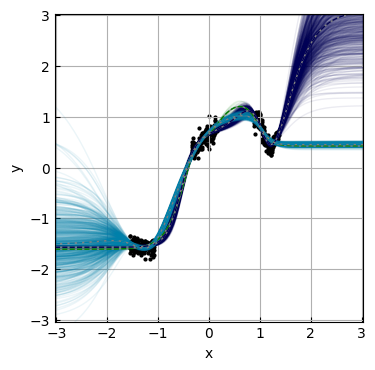

In [15]:
figure = visualization.RegressionFigure(
    settings=settings.SettingsRegressionFigure(
        settings_plot=settings.SettingsPlot(
            alpha=0.08,
            epistemic=False,
            cmap=matplotlib.cm.get_cmap("ocean")
        )
    )
)
figure.plot(
    dataset=experiment._dataset,
    transformation=experiment._model_transformation.apply_from_vector,
    parameters_list=[
        subsets[0][:],
        subsets[1][:],
        subsets[2][:]
    ],
    std=result.samples["std"].mean()
)

100%|█████████████████████████████████████████████████████████████████████████████████████| 648/648 [00:02<00:00, 302.33it/s]


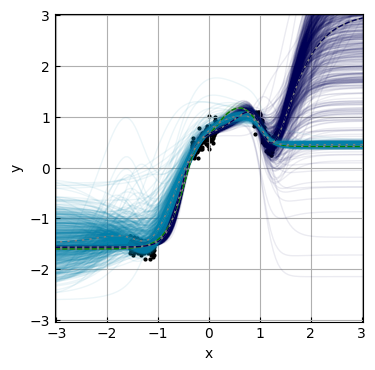

In [16]:
figure = visualization.RegressionFigure(
    settings=settings.SettingsRegressionFigure(
        settings_plot=settings.SettingsPlot(
            alpha=0.08,
            epistemic=False,
            cmap=matplotlib.cm.get_cmap("ocean")
        )
    )
)
figure.plot(
    dataset=experiment._dataset,
    transformation=experiment._model_transformation.apply_from_vector,
    parameters_list=[
        la_samples_custom_0[:],
        la_samples_custom_1[:],
        la_samples_custom_2[:]
    ],
    std=result.samples["std"].mean()
)

In [17]:
# samples parameters
samples_parameters = result.samples["parameters"]
mean = samples_parameters.mean(0)

100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.17it/s]


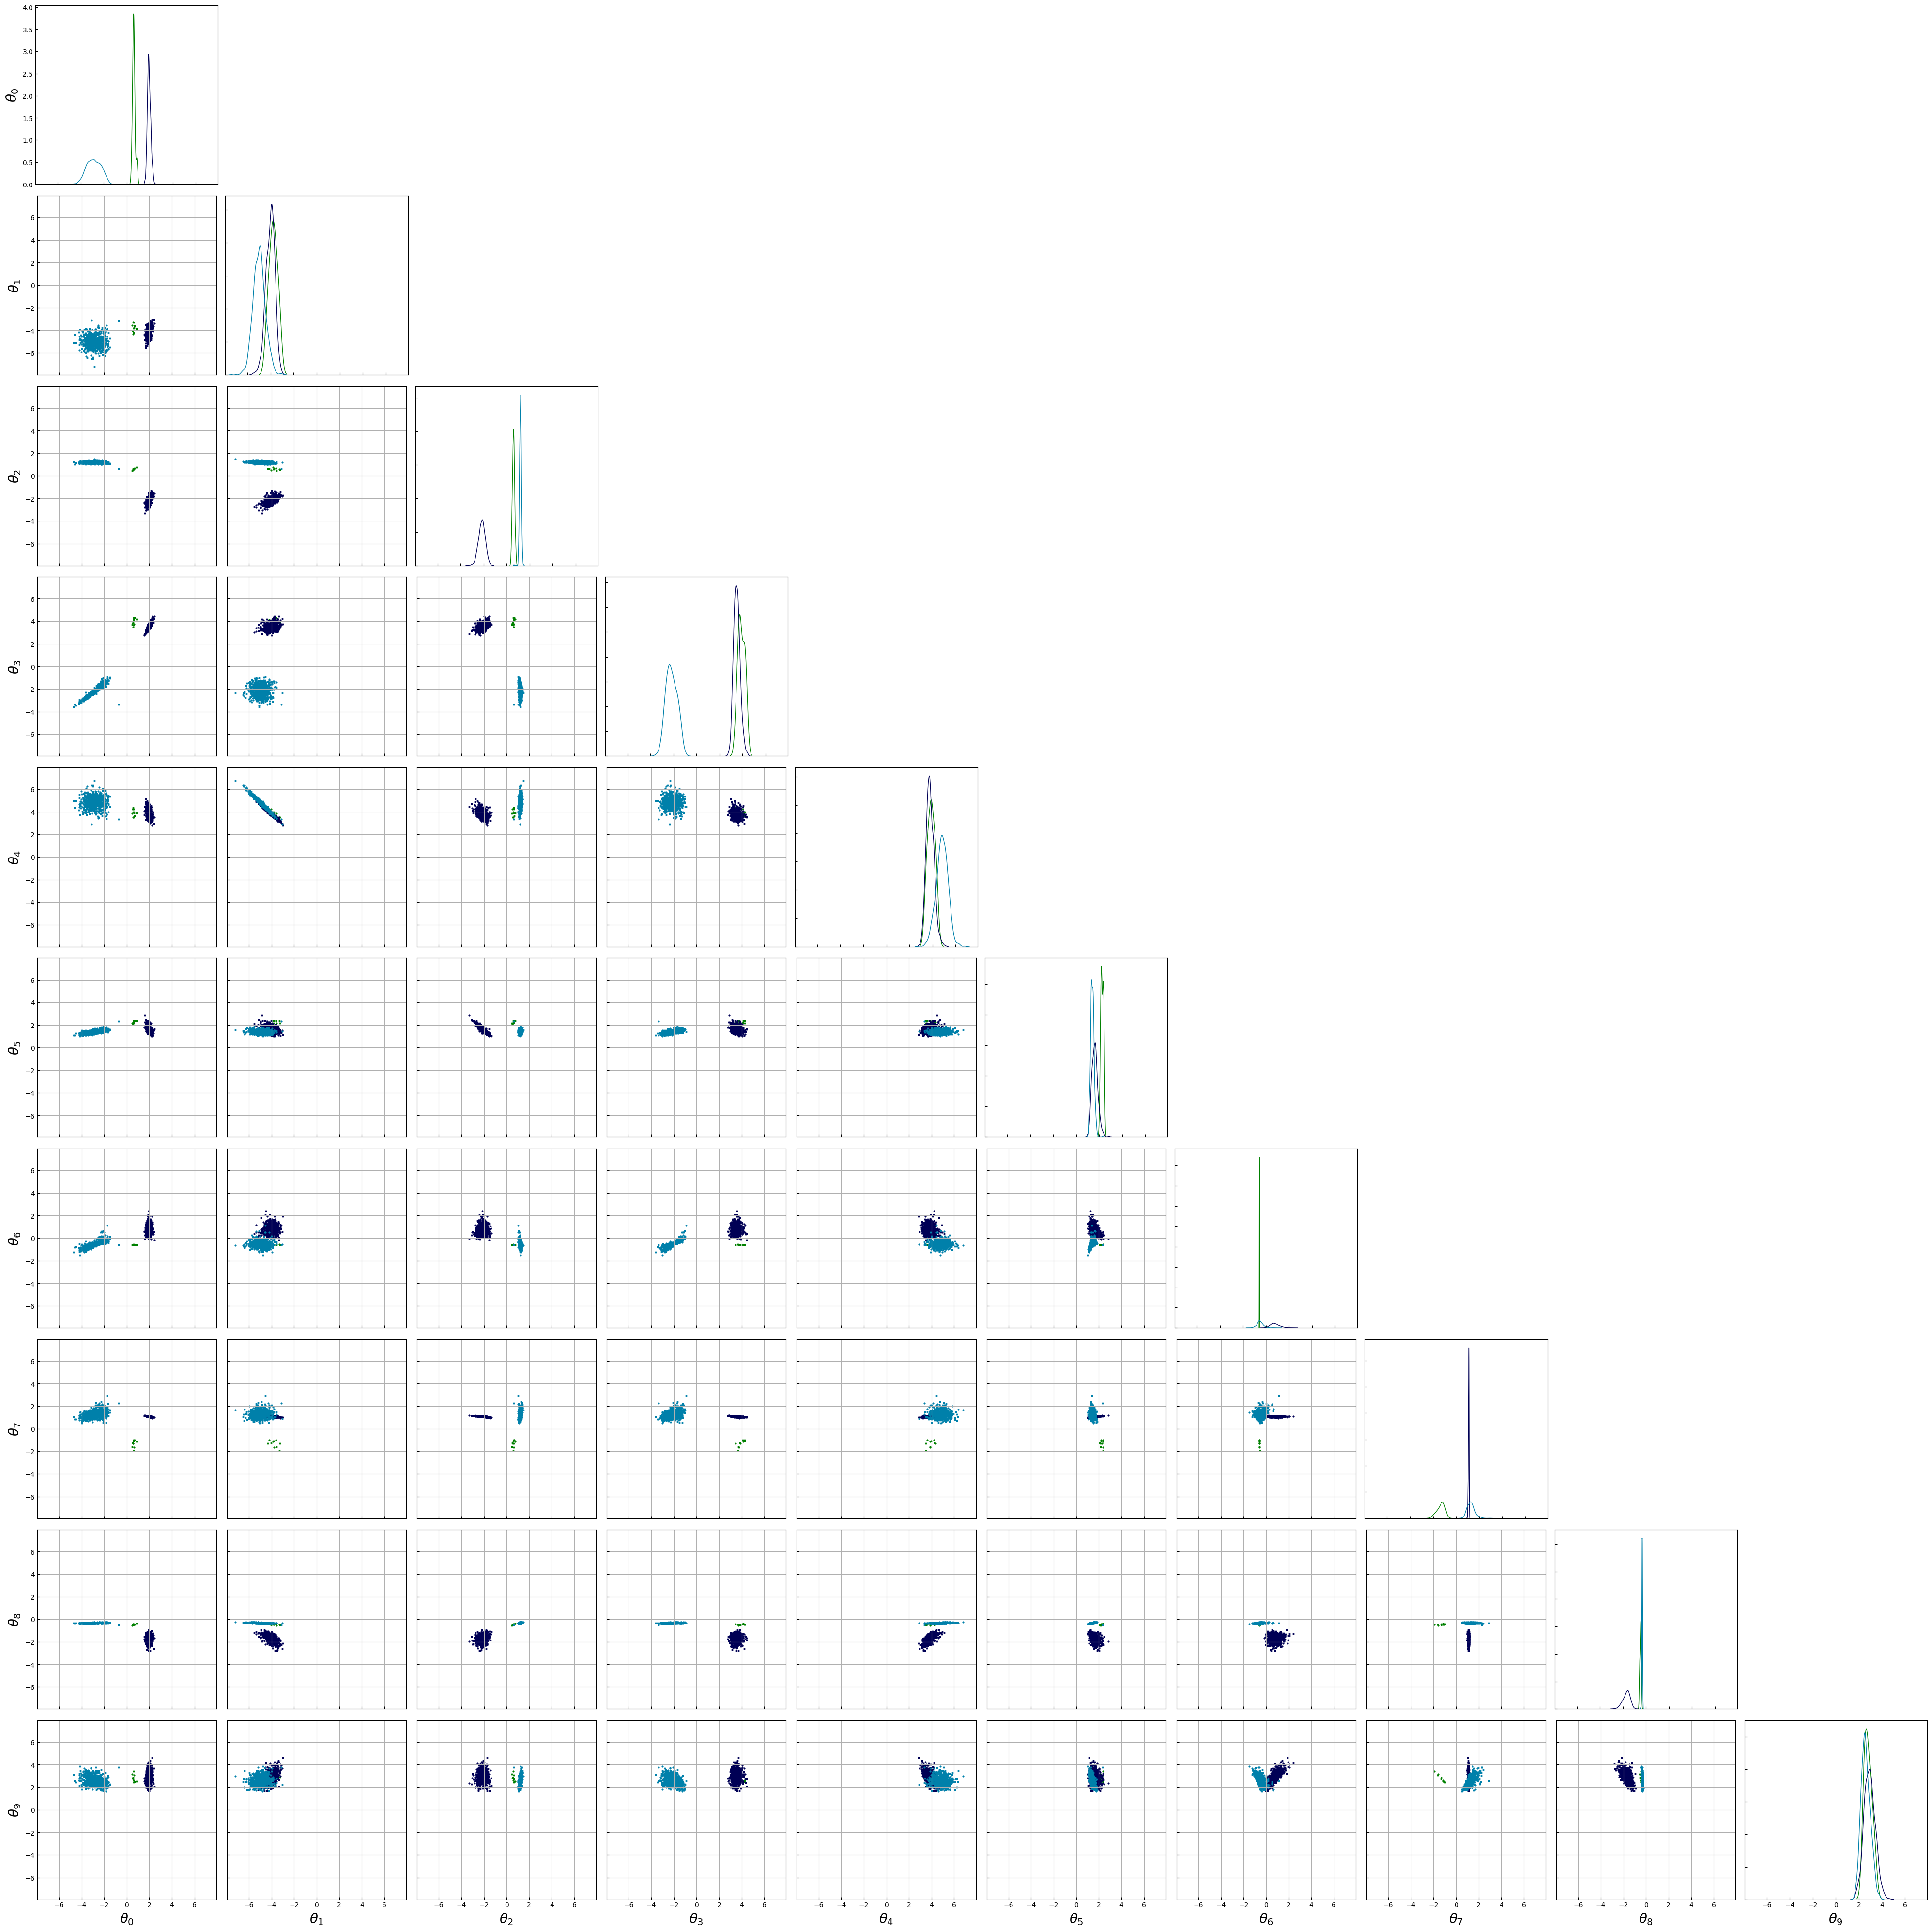

In [18]:
import matplotlib

figure = visualization.TriangleFigure(
    settings=settings.SettingsTriangleFigure(
        ax_width=4.0,
        ax_height=4.0,
        prefix=r"\theta",
        settings_scatter=settings.SettingsScatter(
            alpha=1.0,
            size=4.0
        ),
        label_size=20,
        cmap=matplotlib.cm.get_cmap("ocean")
    )
)
figure.plot(
    data_list=subsets
        #result.samples["parameters"],
        #samples_parameters_reduced
)

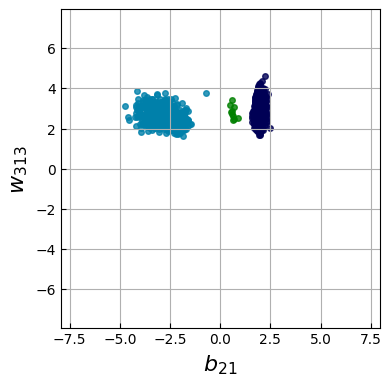

In [19]:
figure = visualization.PaperFigureBivariate(
    settings=settings.SettingsPaperFigureBivariate(
        ax_width=4.0,
        ax_height=4.0,
        prefix=r"\theta",
        settings_scatter=settings.SettingsScatter(
            alpha=0.8,
            size=16.0
        ),
        label_size=16,
        cmap=matplotlib.cm.get_cmap("ocean")
    )
)
figure.plot(
    data_list=subsets,
    scatter_index_0=0, scatter_index_1=9, univariate_index=9,
    labels=[r"$w_{313}$", r"$b_{21}$"],
    rasterized=True, univariate=False
)

# nice plot

In [21]:
i = 0
j = 9
cmap = matplotlib.cm.get_cmap("gist_rainbow")
scale = jnp.std(jnp.concatenate(subsets)) * 3.0
textsize = 24
props = dict(boxstyle='square', facecolor='white', alpha=1.0)
dd = experiment._dataset.data
X = jnp.linspace(-3.0, 3.0, 128)[:, jnp.newaxis]
network = experiment._model_transformation

figure = plt.figure(figsize=(20, 4), tight_layout=True)


# (a)
ax1 = figure.add_subplot(1, 5, 1)
ax1.set_aspect("equal")
ax1.grid(visible=True)
ax1.set_xlim([-scale, scale])
ax1.set_ylim([-scale, scale])
ax1.set_xlabel(r"$b_{21}$")
ax1.set_ylabel(r"$w_{313}$")
ax1.xaxis.label.set_size(textsize)
ax1.yaxis.label.set_size(textsize)
ax1.tick_params(axis='both', which='major', labelsize=textsize - 2)
#ax1.text(-0.1, 0.2, "exp. B", transform=ax1.transAxes, fontsize=textsize, verticalalignment='top', bbox=props)
ax1.text(0.1, 0.9, "a", transform=ax1.transAxes, fontsize=textsize, verticalalignment='top', bbox=props)
for k, element in enumerate(subsets):
    color = cmap(1.0 * k / len(subsets))
    ax1.scatter(element[:, i], element[:, j], s=64, color=color, alpha=0.4, rasterized=True)
    pass

# (b)
color = cmap(1.0 * 0 / len(subsets))
ax2 = figure.add_subplot(1, 5, 2)
ax2.set_aspect("equal")
#ax2.grid(visible=True)
ax2.set_xlim([-3.0, 3.0])
ax2.set_ylim([-3.0, 3.0])
ax2.set_xlabel(r"$x$")
ax2.set_ylabel(r"$y$")
ax2.xaxis.label.set_size(textsize)
ax2.yaxis.label.set_size(textsize)
ax2.tick_params(axis='both', which='major', labelsize=textsize - 2)
ax2.text(0.1, 0.9, "b", transform=ax2.transAxes, fontsize=textsize, verticalalignment='top', bbox=props)
ax2.scatter(dd[:, 0], dd[:, 1], s=4, color="black", alpha=1.0, rasterized=True)
means = jax.vmap(network.apply_from_vector, in_axes=(None, 0))(X, subsets[0]).squeeze(-1)
for mean in means:
    ax2.plot(X, mean, color=color, alpha=0.8, rasterized=True)

# (c)
color = cmap(1.0 * 1 / len(subsets))
ax3 = figure.add_subplot(1, 5, 3)
ax3.set_aspect("equal")
#ax3.grid(visible=True)
ax3.set_xlim([-3.0, 3.0])
ax3.set_ylim([-3.0, 3.0])
ax3.set_xlabel(r"$x$")
#ax3.set_ylabel(r" ")
ax3.xaxis.label.set_size(textsize)
ax3.yaxis.label.set_size(textsize)
ax3.tick_params(axis='both', which='major', labelsize=textsize - 2)
ax3.text(0.1, 0.9, "c", transform=ax3.transAxes, fontsize=textsize, verticalalignment='top', bbox=props)
ax3.scatter(dd[:, 0], dd[:, 1], s=4, color="black", alpha=1.0, rasterized=True)
means = jax.vmap(network.apply_from_vector, in_axes=(None, 0))(X, subsets[1]).squeeze(-1)
for mean in means:
    ax3.plot(X, mean, color=color, alpha=0.08, rasterized=True)

# (d)
color = cmap(1.0 * 2 / len(subsets))
ax4 = figure.add_subplot(1, 5, 4)
ax4.set_aspect("equal")
#ax4.grid(visible=True)
ax4.set_xlim([-3.0, 3.0])
ax4.set_ylim([-3.0, 3.0])
ax4.set_xlabel(r"$x$")
#ax4.set_ylabel(r" ")
ax4.xaxis.label.set_size(textsize)
ax4.yaxis.label.set_size(textsize)
ax4.tick_params(axis='both', which='major', labelsize=textsize - 2)
ax4.text(0.1, 0.9, "d", transform=ax4.transAxes, fontsize=textsize, verticalalignment='top', bbox=props)
ax4.scatter(dd[:, 0], dd[:, 1], s=4, color="black", alpha=1.0, rasterized=True)
means = jax.vmap(network.apply_from_vector, in_axes=(None, 0))(X, subsets[2]).squeeze(-1)
for mean in means:
    ax4.plot(X, mean, color=color, alpha=0.08, rasterized=True)

# (e)
ax5 = figure.add_subplot(1, 5, 5)
ax5.set_aspect("equal")
#ax5.grid(visible=True)
ax5.set_xlim([-3.0, 3.0])
ax5.set_ylim([-3.0, 3.0])
ax5.set_xlabel(r"$x$")
#ax5.set_ylabel(r" ")
ax5.xaxis.label.set_size(textsize)
ax5.yaxis.label.set_size(textsize)
ax5.tick_params(axis='both', which='major', labelsize=textsize - 2)
ax5.text(0.1, 0.9, "e", transform=ax5.transAxes, fontsize=textsize, verticalalignment='top', bbox=props)
ax5.scatter(dd[:, 0], dd[:, 1], s=4, color="black", alpha=1.0, rasterized=True)
for k in enumerate(subsets):
    color = cmap(1.0 * k / len(subsets))
    means = jax.vmap(network.apply_from_vector, in_axes=(None, 0))(X, subsets[k]).squeeze(-1)
    for mean in means:
        ax5.plot(X, mean, color=color, alpha=0.08, rasterized=True)
    
figure

TypeError: can't multiply sequence by non-int of type 'float'

In [ ]:
figure.savefig(os.path.join(global_settings.PATH_FIGURES, "figure_04.pdf"), bbox_inches="tight", dpi=192, transparent=True)

In [ ]:
subsets_r = [la_samples_custom_0, la_samples_custom_1, la_samples_custom_2]

In [ ]:
i = 0
j = 9
cmap = matplotlib.cm.get_cmap("gist_rainbow")
scale = jnp.std(jnp.concatenate(subsets_r)) * 3.0
textsize = 24
props = dict(boxstyle='square', facecolor='white', alpha=1.0)
dd = experiment._dataset.data
X = jnp.linspace(-3.0, 3.0, 128)[:, jnp.newaxis]
network = experiment._model_transformation

figure = plt.figure(figsize=(20, 4), tight_layout=True)


# (a)
ax1 = figure.add_subplot(1, 5, 1)
ax1.set_aspect("equal")
ax1.grid(visible=True)
ax1.set_xlim([-scale, scale])
ax1.set_ylim([-scale, scale])
ax1.set_xlabel(r"$b_{21}$")
ax1.set_ylabel(r"$w_{313}$")
ax1.xaxis.label.set_size(textsize)
ax1.yaxis.label.set_size(textsize)
ax1.tick_params(axis='both', which='major', labelsize=textsize - 2)
#ax1.text(-0.1, 0.2, "exp. B", transform=ax1.transAxes, fontsize=textsize, verticalalignment='top', bbox=props)
ax1.text(0.1, 0.9, "a", transform=ax1.transAxes, fontsize=textsize, verticalalignment='top', bbox=props)
for k, element in enumerate(subsets_r):
    color = cmap(1.0 * k / len(subsets_r))
    ax1.scatter(element[:, i], element[:, j], s=64, color=color, alpha=0.4, rasterized=True)
    pass

# (b)
color = cmap(1.0 * 0 / len(subsets_r))
ax2 = figure.add_subplot(1, 5, 2)
ax2.set_aspect("equal")
#ax2.grid(visible=True)
ax2.set_xlim([-3.0, 3.0])
ax2.set_ylim([-3.0, 3.0])
ax2.set_xlabel(r"$x$")
ax2.set_ylabel(r"$y$")
ax2.xaxis.label.set_size(textsize)
ax2.yaxis.label.set_size(textsize)
ax2.tick_params(axis='both', which='major', labelsize=textsize - 2)
ax2.text(0.1, 0.9, "b", transform=ax2.transAxes, fontsize=textsize, verticalalignment='top', bbox=props)
ax2.scatter(dd[:, 0], dd[:, 1], s=4, color="black", alpha=1.0, rasterized=True)
means = jax.vmap(network.apply_from_vector, in_axes=(None, 0))(X, subsets_r[0]).squeeze(-1)
for mean in means:
    ax2.plot(X, mean, color=color, alpha=0.8, rasterized=True)

# (c)
color = cmap(1.0 * 1 / len(subsets_r))
ax3 = figure.add_subplot(1, 5, 3)
ax3.set_aspect("equal")
#ax3.grid(visible=True)
ax3.set_xlim([-3.0, 3.0])
ax3.set_ylim([-3.0, 3.0])
ax3.set_xlabel(r"$x$")
#ax3.set_ylabel(r" ")
ax3.xaxis.label.set_size(textsize)
ax3.yaxis.label.set_size(textsize)
ax3.tick_params(axis='both', which='major', labelsize=textsize - 2)
ax3.text(0.1, 0.9, "c", transform=ax3.transAxes, fontsize=textsize, verticalalignment='top', bbox=props)
ax3.scatter(dd[:, 0], dd[:, 1], s=4, color="black", alpha=1.0, rasterized=True)
means = jax.vmap(network.apply_from_vector, in_axes=(None, 0))(X, subsets_r[1]).squeeze(-1)
for mean in means:
    ax3.plot(X, mean, color=color, alpha=0.08, rasterized=True)

# (d)
color = cmap(1.0 * 2 / len(subsets_r))
ax4 = figure.add_subplot(1, 5, 4)
ax4.set_aspect("equal")
#ax4.grid(visible=True)
ax4.set_xlim([-3.0, 3.0])
ax4.set_ylim([-3.0, 3.0])
ax4.set_xlabel(r"$x$")
#ax4.set_ylabel(r" ")
ax4.xaxis.label.set_size(textsize)
ax4.yaxis.label.set_size(textsize)
ax4.tick_params(axis='both', which='major', labelsize=textsize - 2)
ax4.text(0.1, 0.9, "d", transform=ax4.transAxes, fontsize=textsize, verticalalignment='top', bbox=props)
ax4.scatter(dd[:, 0], dd[:, 1], s=4, color="black", alpha=1.0, rasterized=True)
means = jax.vmap(network.apply_from_vector, in_axes=(None, 0))(X, subsets_r[2]).squeeze(-1)
for mean in means:
    ax4.plot(X, mean, color=color, alpha=0.08, rasterized=True)

# (e)
ax5 = figure.add_subplot(1, 5, 5)
ax5.set_aspect("equal")
#ax5.grid(visible=True)
ax5.set_xlim([-3.0, 3.0])
ax5.set_ylim([-3.0, 3.0])
ax5.set_xlabel(r"$x$")
#ax5.set_ylabel(r" ")
ax5.xaxis.label.set_size(textsize)
ax5.yaxis.label.set_size(textsize)
ax5.tick_params(axis='both', which='major', labelsize=textsize - 2)
ax5.text(0.1, 0.9, "e", transform=ax5.transAxes, fontsize=textsize, verticalalignment='top', bbox=props)
ax5.scatter(dd[:, 0], dd[:, 1], s=4, color="black", alpha=1.0, rasterized=True)
for k in [2, 1, 0]:
    color = cmap(1.0 * k / len(subsets_r))
    means = jax.vmap(network.apply_from_vector, in_axes=(None, 0))(X, subsets_r[k]).squeeze(-1)
    for mean in means:
        ax5.plot(X, mean, color=color, alpha=0.08, rasterized=True)
    
figure

In [ ]:
figure.savefig(os.path.join(global_settings.PATH_FIGURES, "figure_mola.pdf"), bbox_inches="tight", dpi=192, transparent=True)